# Proyecto 2. Entrega 5. Modelos de Regresión Logística

## 1. Cree una variable dicotómica por cada una de las categorías de la variable respuesta categórica que creó en hojas anteriores. Debería tener 3 variables dicotómicas (valores 0 y 1) una que diga si la vivienda es cara o no, media o no, económica o no.

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd

df = pd.read_csv("train.csv")

# Calcular los cuartiles
q1 = df['SalePrice'].quantile(0.25)
q3 = df['SalePrice'].quantile(0.75)

# Función para clasificar el precio
def categorizar_precio(precio):
    if precio < q1:           
        return 'barata'
    elif precio < q3:          
        return 'media'
    else:
        return 'cara'

# Crear columna categórica
df['precio_vivienda'] = df['SalePrice'].apply(categorizar_precio)

# Crear variables dicotómicas (0 o 1)
df['barata'] = (df['precio_vivienda'] == 'barata').astype(int)
df['media'] = (df['precio_vivienda'] == 'media').astype(int)
df['cara'] = (df['precio_vivienda'] == 'cara').astype(int)

print(df[['SalePrice', 'precio_vivienda', 'barata', 'media', 'cara']].head(10))
print("")
print(df['precio_vivienda'].value_counts())

   SalePrice precio_vivienda  barata  media  cara
0     208500           media       0      1     0
1     181500           media       0      1     0
2     223500            cara       0      0     1
3     140000           media       0      1     0
4     250000            cara       0      0     1
5     143000           media       0      1     0
6     307000            cara       0      0     1
7     200000           media       0      1     0
8     129900          barata       1      0     0
9     118000          barata       1      0     0

precio_vivienda
media     728
cara      367
barata    365
Name: count, dtype: int64


## 2. Use los mismos conjuntos de entrenamiento y prueba que utilizó en las hojas anteriores

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = df.select_dtypes(include='number').drop(columns=['Id', 'SalePrice', 'barata', 'media', 'cara'])

# Variable objetivo: 1 si es "cara", 0 si no
y = df['cara']

# Dividir (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

imputer = SimpleImputer(strategy='mean')

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train distribución:\n{y_train.value_counts()}")
print(f"y_test distribución:\n{y_test.value_counts()}")

X_train: (1168, 36)
X_test: (292, 36)
y_train distribución:
cara
0    871
1    297
Name: count, dtype: int64
y_test distribución:
cara
0    222
1     70
Name: count, dtype: int64


## 3. Elabore un modelo de regresión logística para conocer si una vivienda es cara o no, utilizando el conjunto de entrenamiento y explique los resultados a los que llega. El experimento debe ser reproducible por lo que debe fijar que los conjuntos de entrenamiento y prueba sean los mismos siempre que se ejecute el código. Use validación cruzada.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

model = LogisticRegression(max_iter=5000)

# 3. Validación cruzada con 5 folds
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Accuracy por fold:", scores)
print("Promedio de accuracy:", scores.mean())

Accuracy por fold: [0.92307692 0.91880342 0.94017094 0.93133047 0.95708155]
Promedio de accuracy: 0.9340926598437328


## 4. Analice el modelo. Determine si hay multicolinealidad en las variables, y cuáles son las que aportan al modelo, por su valor de significación. Haga un análisis de correlación de las variables del modelo y especifique si el modelo se adapta bien a los datos.

### VIF (Multicolinealidad)

In [8]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_vif = pd.DataFrame(X_train, columns=X.columns)  

X_vif_const = add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]

print(vif_data)

         Variable           VIF
0           const  2.447141e+06
1      MSSubClass  1.678579e+00
2     LotFrontage  1.550509e+00
3         LotArea  1.258606e+00
4     OverallQual  3.184199e+00
5     OverallCond  1.586181e+00
6       YearBuilt  5.094617e+00
7    YearRemodAdd  2.422516e+00
8      MasVnrArea  1.410436e+00
9      BsmtFinSF1           inf
10     BsmtFinSF2           inf
11      BsmtUnfSF           inf
12    TotalBsmtSF           inf
13       1stFlrSF           inf
14       2ndFlrSF           inf
15   LowQualFinSF           inf
16      GrLivArea           inf
17   BsmtFullBath  2.197736e+00
18   BsmtHalfBath  1.164117e+00
19       FullBath  2.951514e+00
20       HalfBath  2.110857e+00
21   BedroomAbvGr  2.372205e+00
22   KitchenAbvGr  1.658490e+00
23   TotRmsAbvGrd  5.003023e+00
24     Fireplaces  1.579476e+00
25    GarageYrBlt  3.261961e+00
26     GarageCars  5.578335e+00
27     GarageArea  5.529931e+00
28     WoodDeckSF  1.239912e+00
29    OpenPorchSF  1.232406e+00
30  Encl

### Matriz de correlación

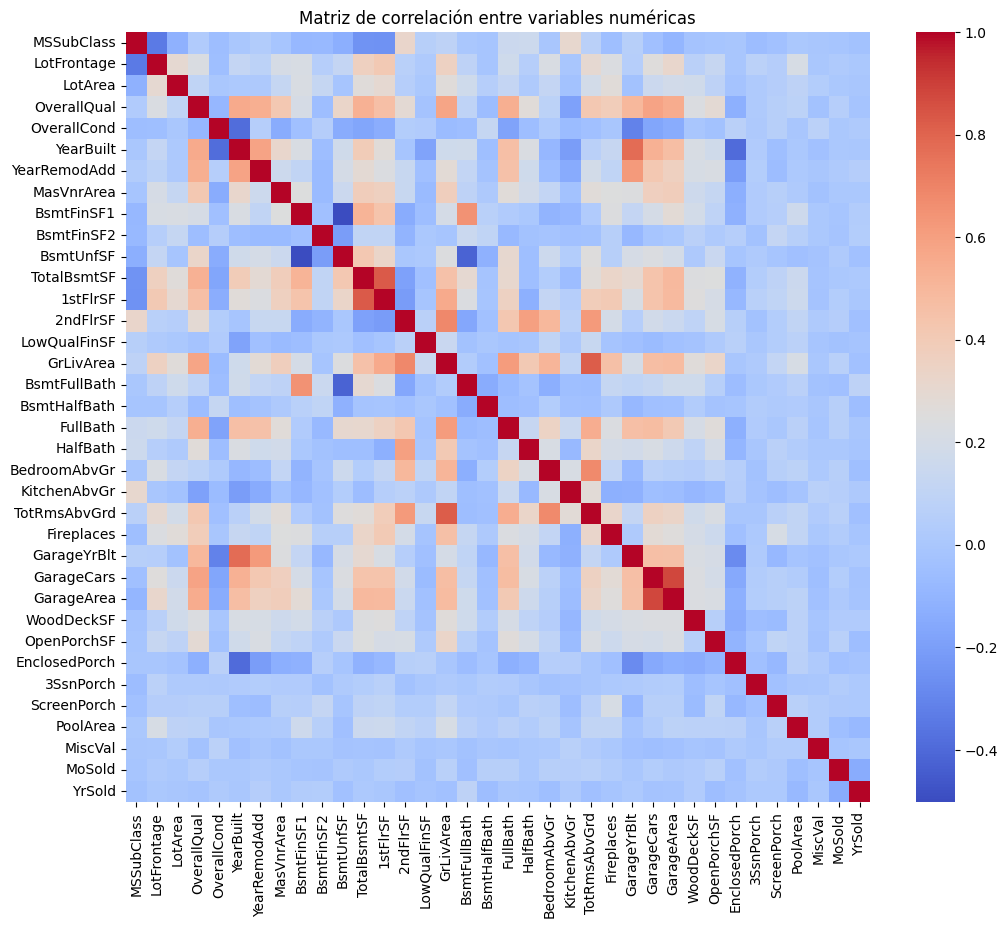

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_vif.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

## 5. Utilice el modelo con el conjunto de prueba y determine la eficiencia del algoritmo para clasificar.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_train = imputer.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)

X_test = imputer.transform(X_test)
X_test = scaler.transform(X_test)

model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy en el conjunto de prueba:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred))

Accuracy en el conjunto de prueba: 0.952054794520548

Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       222
           1       0.94      0.86      0.90        70

    accuracy                           0.95       292
   macro avg       0.95      0.92      0.93       292
weighted avg       0.95      0.95      0.95       292

